In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import spacy

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import classification_report as report
from sklearn.feature_extraction.text import CountVectorizer


### Apply sepsis label to lab and text data

In [2]:
noteevents = pd.read_csv("noteevents_full_icustays.csv") #all text for all patients
patients = pd.read_csv("combined_patients_no_text.csv") #all patient data except for text, including presumed sepsis onset

In [3]:
patients.columns

Index(['Unnamed: 0', 'a:action', 'm:charttime', 'm:icustayid',
       'm:presumed_onset', 'o:Arterial_BE', 'o:Arterial_lactate',
       'o:Arterial_pH', 'o:BUN', 'o:Calcium', 'o:Chloride', 'o:Creatinine',
       'o:DiaBP', 'o:FiO2_1', 'o:GCS', 'o:Glucose', 'o:HCO3', 'o:HR', 'o:Hb',
       'o:INR', 'o:Magnesium', 'o:MeanBP', 'o:PT', 'o:PTT', 'o:PaO2_FiO2',
       'o:Platelets_count', 'o:Potassium', 'o:RR', 'o:SGOT', 'o:SGPT',
       'o:SIRS', 'o:SOFA', 'o:Shock_Index', 'o:Sodium', 'o:SpO2', 'o:SysBP',
       'o:Temp_C', 'o:Total_bili', 'o:WBC_count', 'o:Weight_kg', 'o:age',
       'o:cumulated_balance', 'o:gender', 'o:input_4hourly', 'o:input_total',
       'o:max_dose_vaso', 'o:mechvent', 'o:output_4hourly', 'o:output_total',
       'o:paCO2', 'o:paO2', 'o:re_admission', 'r:reward', 'step', 'traj'],
      dtype='object')

In [4]:
sorted(np.unique(patients["m:presumed_onset"]))

[0.0,
 4116096000.0,
 4116282420.0,
 4116681600.0,
 4117651200.0,
 4118256000.0,
 4118817600.0,
 4118860800.0,
 4119292800.0,
 4119874140.0,
 4120451520.0,
 4120934400.0,
 4121193600.0,
 4121366400.0,
 4121412300.0,
 4121613240.0,
 4122219300.0,
 4122394740.0,
 4122489600.0,
 4122582480.0,
 4122706140.0,
 4122748800.0,
 4122796560.0,
 4122798180.0,
 4122802800.0,
 4122976500.0,
 4123353600.0,
 4123364880.0,
 4123414800.0,
 4123910160.0,
 4124030400.0,
 4124102880.0,
 4124104980.0,
 4124173860.0,
 4124625000.0,
 4124822400.0,
 4124908800.0,
 4125029040.0,
 4125305100.0,
 4125427200.0,
 4125499980.0,
 4125686400.0,
 4125772800.0,
 4125816360.0,
 4125826800.0,
 4125829080.0,
 4125859200.0,
 4126118400.0,
 4126550400.0,
 4126803300.0,
 4126807560.0,
 4126930740.0,
 4127047500.0,
 4127234400.0,
 4127328000.0,
 4127673600.0,
 4128105600.0,
 4128364800.0,
 4128796800.0,
 4128969600.0,
 4129184700.0,
 4129315200.0,
 4129360980.0,
 4129656180.0,
 4129660800.0,
 4130265600.0,
 4130784000.0,
 413

In [8]:
patients["sepsis_label"] = np.where(patients["m:presumed_onset"] > 0.0, 1, 0)

In [14]:
patients["sepsis_label"].value_counts()

sepsis_label
0    1102706
1     889233
Name: count, dtype: int64

In [24]:
ids = np.unique(patients["m:icustayid"]).astype("int")
ids

array([200003, 200006, 200007, ..., 299993, 299995, 299999])

In [40]:
x = []
y = []
i = 0
for id in tqdm(ids):
    # get the label for each icustayid and create lookup
    label = np.unique(patients["sepsis_label"].loc[patients["m:icustayid"] == id]).astype("int")
    x.append(id)
    y.append(label.item())
lookup = pd.DataFrame({"icustayid": x,
                       "label": y})

100%|██████████| 43388/43388 [01:17<00:00, 560.17it/s]


In [48]:
lookup["label"].loc[lookup["icustayid"]==200003].item()

1

In [3]:
for id in tqdm(ids):
    label = lookup["label"].loc[lookup["icustayid"]==id].item()
    noteevents.loc[noteevents["icustay_id"] == id, "sepsis_label"] = label

NameError: name 'ids' is not defined

In [50]:
patients.to_csv("patients_no_text_sepsis_labels.csv")

In [1]:
noteevents.to_csv("noteevents_full_icustays_sepsis_labels.csv")

NameError: name 'noteevents' is not defined

### Begin here to load labeled data

In [2]:
lab = pd.read_csv("patients_no_text_sepsis_labels.csv")
noteevents = pd.read_csv("noteevents_full_icustays_sepsis_labels.csv")

In [3]:
lab.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'a:action', 'm:charttime', 'm:icustayid',
       'm:presumed_onset', 'o:Arterial_BE', 'o:Arterial_lactate',
       'o:Arterial_pH', 'o:BUN', 'o:Calcium', 'o:Chloride', 'o:Creatinine',
       'o:DiaBP', 'o:FiO2_1', 'o:GCS', 'o:Glucose', 'o:HCO3', 'o:HR', 'o:Hb',
       'o:INR', 'o:Magnesium', 'o:MeanBP', 'o:PT', 'o:PTT', 'o:PaO2_FiO2',
       'o:Platelets_count', 'o:Potassium', 'o:RR', 'o:SGOT', 'o:SGPT',
       'o:SIRS', 'o:SOFA', 'o:Shock_Index', 'o:Sodium', 'o:SpO2', 'o:SysBP',
       'o:Temp_C', 'o:Total_bili', 'o:WBC_count', 'o:Weight_kg', 'o:age',
       'o:cumulated_balance', 'o:gender', 'o:input_4hourly', 'o:input_total',
       'o:max_dose_vaso', 'o:mechvent', 'o:output_4hourly', 'o:output_total',
       'o:paCO2', 'o:paO2', 'o:re_admission', 'r:reward', 'step', 'traj',
       'sepsis_label'],
      dtype='object')

### evaluate feature importance for lab values

In [4]:
print(lab.step.value_counts(bins=5, normalize=True))

step
(-0.079, 15.6]    0.340063
(15.6, 31.2]      0.290511
(31.2, 46.8]      0.187400
(46.8, 62.4]      0.121931
(62.4, 78.0]      0.060095
Name: proportion, dtype: float64


In [3]:
# min step sets how many consecutive steps (in this case hours) patient data needs to contain to be included for feature importance extraction
min_step = 12
# drop some unneccessary columns, get relevant ICUSTAYIDs and rename columns, so that we can proceed
data = lab.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'a:action','r:reward'])
ids = data["m:icustayid"].loc[data["step"] == min_step]
df_ = data.loc[data["m:icustayid"].isin(ids)]
t = noteevents.loc[noteevents["icustay_id"].isin(ids)]
t = t.rename(columns={"icustay_id": "m:icustayid"})
t["m:presumed_onset"] = np.nan

In [4]:
for id in tqdm(ids):
    onset = np.unique(df_["m:presumed_onset"].loc[df_["m:icustayid"] == id])#.astype("int")
    t.loc[t["m:icustayid"] == id, "m:presumed_onset"] = onset[0]

100%|██████████| 41871/41871 [02:53<00:00, 240.77it/s]


In [31]:
# 41871 patients with at least 11 steps
print(len(ids), len(np.unique(df_["m:icustayid"])), len(np.unique(t["m:icustayid"])))

41871 41871 41774


In [32]:
print(len(t))

1311540


In [33]:
df_.isna().sum()


m:charttime                  0
m:icustayid                  0
m:presumed_onset             0
o:Arterial_BE                0
o:Arterial_lactate           0
o:Arterial_pH                0
o:BUN                        0
o:Calcium                    0
o:Chloride                   0
o:Creatinine                 0
o:DiaBP                      0
o:FiO2_1                     0
o:GCS                        0
o:Glucose                    0
o:HCO3                       0
o:HR                         0
o:Hb                         0
o:INR                        0
o:Magnesium                  0
o:MeanBP                     0
o:PT                         0
o:PTT                        0
o:PaO2_FiO2             885027
o:Platelets_count            0
o:Potassium                  0
o:RR                         0
o:SGOT                       0
o:SGPT                       0
o:SIRS                       0
o:SOFA                       0
o:Shock_Index                0
o:Sodium                     0
o:SpO2  

In [34]:
t.isna().sum()

Unnamed: 0                0
subject_id                0
hadm_id               94169
category                  0
description               0
iserror             1310775
text                      0
charttime            220971
chartdate                 0
storetime            583274
m:icustayid               0
sepsis_label              0
m:presumed_onset          0
dtype: int64

In [28]:
ids.iloc[0]

200003.0

In [5]:
# create granular label: for patients with presumed onset, if chartdate < presumed onset = 0, else 1.
df_["granular_label"] = np.where(((df_["m:charttime"] >= df_["m:presumed_onset"]) & (df_["m:presumed_onset"] > 0.0)), 1, 0)
t["granular_label"] = np.where(((t["chartdate"] >= t["m:presumed_onset"]) & (t["m:presumed_onset"] > 0.0)), 1, 0)
t[["m:presumed_onset", "granular_label", "chartdate","sepsis_label"]].loc[t["m:icustayid"]==ids.iloc[0]]
    

C:\Users\pablo\AppData\Local\Temp\ipykernel_4392\3902783763.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_["granular_label"] = np.where(((df_["m:charttime"] >= df_["m:presumed_onset"]) & (df_["m:presumed_onset"] > 0.0)), 1, 0)


,m:presumed_onset,granular_label,chartdate,sepsis_label
1147423,7.245590e+09,0,7.245072e+09,1.0
1147424,7.245590e+09,0,7.245072e+09,1.0
1147425,7.245590e+09,0,7.245072e+09,1.0
1147426,7.245590e+09,0,7.245072e+09,1.0
1147427,7.245590e+09,0,7.245072e+09,1.0
1147428,7.245590e+09,0,7.245072e+09,1.0
1147429,7.245590e+09,0,7.245072e+09,1.0
1147430,7.245590e+09,0,7.245072e+09,1.0
1147431,7.245590e+09,0,7.245158e+09,1.0
1147432,7.245590e+09,0,7.245158e+09,1.0


In [6]:
#make groundtruth for the selected patients
ground_truth = []
for id in tqdm(ids):
    # get the label for each icustayid and create lookup
    label = np.unique(df_["sepsis_label"].loc[df_["m:icustayid"] == id]).astype("int")
    ground_truth.append(label.item())
#drop empty features, as well as SOFA and SIRS as they are processed from other lab features
df = df_.drop(columns=["o:output_4hourly", "o:output_total", "o:SOFA", "o:SIRS", "step", "traj", "sepsis_label", "o:input_4hourly", "o:input_total", "o:PaO2_FiO2", "o:GCS", "o:PTT", "o:DiaBP", "o:MeanBP", "o:SpO2", "o:cumulated_balance"])
#occurences of septic and non septic in selected patients
Counter(ground_truth).items()

100%|██████████| 41871/41871 [01:18<00:00, 531.05it/s]


dict_items([(1, 18043), (0, 23828)])

In [9]:
df.columns

Index(['m:charttime', 'm:icustayid', 'o:Arterial_BE', 'o:Arterial_lactate',
       'o:Arterial_pH', 'o:BUN', 'o:Calcium', 'o:Chloride', 'o:Creatinine',
       'o:FiO2_1', 'o:Glucose', 'o:HCO3', 'o:HR', 'o:Hb', 'o:INR',
       'o:Magnesium', 'o:PT', 'o:Platelets_count', 'o:Potassium', 'o:RR',
       'o:SGOT', 'o:SGPT', 'o:Shock_Index', 'o:Sodium', 'o:SysBP', 'o:Temp_C',
       'o:Total_bili', 'o:WBC_count', 'o:Weight_kg', 'o:age', 'o:gender',
       'o:max_dose_vaso', 'o:mechvent', 'o:paCO2', 'o:paO2', 'o:re_admission'],
      dtype='object')

In [6]:
cols = list(df.columns)
temp2 = []
for id in tqdm(ids):
    #grab data of one patient
    df_raw = df.loc[df["m:icustayid"] == id] 
    #drop icustayid to avoid learning the id to label correspondence
    d = df_raw.drop(columns=["m:icustayid", "m:charttime"])
    #flatten all features and corresponding values of all timesteps into single sequence, used for classifier, feature importance etc
    temp2.append(list(d.values.flatten()))
df_raw = df.loc[df["m:icustayid"] == id] 
d = df_raw.drop(columns=["m:icustayid", "m:charttime"])
cols = list(d.columns)


100%|██████████| 41871/41871 [01:34<00:00, 442.98it/s]


In [11]:
cols

['o:Arterial_BE',
 'o:Arterial_lactate',
 'o:Arterial_pH',
 'o:BUN',
 'o:Calcium',
 'o:Chloride',
 'o:Creatinine',
 'o:FiO2_1',
 'o:Glucose',
 'o:HCO3',
 'o:HR',
 'o:Hb',
 'o:INR',
 'o:Magnesium',
 'o:PT',
 'o:Platelets_count',
 'o:Potassium',
 'o:RR',
 'o:SGOT',
 'o:SGPT',
 'o:Shock_Index',
 'o:Sodium',
 'o:SysBP',
 'o:Temp_C',
 'o:Total_bili',
 'o:WBC_count',
 'o:Weight_kg',
 'o:age',
 'o:gender',
 'o:max_dose_vaso',
 'o:mechvent',
 'o:paCO2',
 'o:paO2',
 'o:re_admission']

In [7]:
# trim data to equal length for classification
thresh = min_step*(len(cols)) #-1 since we remove icustayids afterwards, length of data * number of features = one patient for prediction/training
#cutoff = list(filter(lambda i: len(i) >= thresh, temp2))
#ground_truth_cutoff = [ground_truth["sepsis_label"][x] for x, i in enumerate(datalist) if len(i) >= thresh]

preprocessed_data = [element[:thresh] for element in temp2] # should be shape [#ofpatients, minstep*#offeatures]
print(f"shape of preprocessed data: [{len(preprocessed_data)}, {len(preprocessed_data[0])}]")
print(f"number of patients: {len(temp2)}")
print(f"length of ground truth: {len(ground_truth)}")
print(f"length of desired patient data: {thresh}")



shape of preprocessed data: [41871, 408]
number of patients: 41871
length of ground truth: 41871
length of desired patient data: 408


In [13]:
df_data = pd.DataFrame(preprocessed_data)
df_data

,0,1,2,3,4,5,6,7,8,9,...,398,399,400,401,402,403,404,405,406,407
0,1.071661,-0.560359,1.069870,-0.380498,0.094949,-0.115152,-0.151959,0.270372,-0.431229,1.257526,...,1.695768,0.298152,-0.165619,-0.963438,-0.5,-2.302585,-0.5,0.342991,2.502016,-0.5
1,1.071661,-0.807791,-1.359161,1.099965,0.094949,-0.275503,0.872138,-0.829653,-0.336055,1.456557,...,-0.481630,-0.524785,0.772330,1.187623,0.5,-2.302585,0.5,3.034376,-1.125315,0.5
2,-1.013271,2.161392,-1.359161,0.110697,-0.775842,1.167654,-0.867791,-0.279641,-0.488332,-0.135694,...,-0.886884,0.272831,-0.450723,1.217268,-0.5,-2.302585,0.5,-0.464425,0.110725,-0.5
3,-0.086635,0.016982,0.195419,0.521029,1.090139,0.045199,0.339249,-0.499646,-0.577161,-0.732788,...,-0.481630,0.095583,1.276426,-0.610490,-0.5,-2.302585,-0.5,-1.182127,-0.600200,-0.5
4,1.998297,0.264414,0.584064,0.521029,3.702513,-0.115152,0.339249,-1.324664,-0.355090,-0.732788,...,0.434184,-0.828638,-0.401139,0.164828,-0.5,-2.302585,-0.5,0.881268,0.498502,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41866,0.498824,-0.291916,-0.257693,0.798865,0.910616,-0.704312,1.605759,0.109145,-0.684329,-0.644026,...,0.857872,-0.282480,0.254079,-0.456686,-0.5,-2.302585,-0.5,0.892817,-0.381476,-0.5
41867,-0.537904,1.065483,-0.547534,0.471950,0.231097,0.191409,-0.228448,-0.340459,0.055309,-0.175933,...,-0.891924,1.762800,0.164370,0.122087,-0.5,-1.123930,-0.5,-1.229844,-0.385573,-0.5
41868,-1.185859,1.668771,-0.040313,0.242901,0.367001,0.728841,-0.316105,-0.340459,0.872804,-0.644026,...,0.025693,-0.793800,1.608256,-0.160118,-0.5,-2.302585,-0.5,-0.391262,-0.246279,-0.5
41869,-0.969874,-0.518149,0.853363,0.207179,1.726039,-1.600032,-0.316105,-0.115657,0.872804,-0.175933,...,-0.355152,0.182357,-1.616993,-2.147015,-0.5,-2.302585,-0.5,0.132852,-0.008660,-0.5


In [8]:
duplicates = df_data.duplicated()
duplicates.value_counts()

NameError: name 'df_data' is not defined

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df_data, ground_truth, test_size=0.30, random_state=100,stratify=ground_truth)

In [18]:
print(f"Shape of X_train: {len(X_train)}")
print(f"Shape of X_test: {len(X_test)}")
print("Class Balance in Training Data:", Counter(y_train).items())
print("Class Balance in Test Data:", Counter(y_test).items())


Shape of X_train: 29309
Shape of X_test: 12562
Class Balance in Training Data: dict_items([(0, 16679), (1, 12630)])
Class Balance in Test Data: dict_items([(0, 7149), (1, 5413)])


In [16]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,1230,1231,1232,1233,1234,1235,1236,1237,1238,1239
15602,-0.019540,-0.895205,0.321988,1.108495,1.726039,-0.704312,0.010399,-0.051725,-0.115657,0.509088,...,-0.205007,-0.399515,0.004282,0.044881,-0.5,-2.302585,-0.5,0.342498,-0.459317,-0.5
26115,3.090643,-0.291916,-2.576419,-0.113414,0.367001,-1.241744,-1.101423,0.005009,1.233155,0.509088,...,-0.499403,0.198544,-0.314251,0.155233,-0.5,-2.302585,0.5,2.229308,-0.729711,-0.5
28289,-0.019540,0.235961,0.177068,1.495359,0.706760,-0.346024,0.346567,0.051221,-0.565261,0.509088,...,-0.406436,-0.489224,0.053700,0.557029,-0.5,-2.302585,-0.5,-0.391262,1.826743,-0.5
2732,2.461615,0.016982,-0.096065,1.488530,1.338937,-1.558309,3.390630,0.231259,-0.554647,-0.528819,...,-0.752675,-0.190411,-0.182240,-0.071659,-0.5,-2.302585,-0.5,0.432704,1.597203,-0.5
16301,0.239642,1.442538,-0.112773,-0.683553,0.095193,-0.346024,-0.346353,0.080046,-0.565261,0.509088,...,-0.065556,0.493302,0.064651,-0.990462,-0.5,-2.302585,-0.5,2.963067,0.163409,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25806,-1.833814,0.085139,-1.417056,1.331551,1.861943,1.624561,0.776050,-0.040745,-0.958665,0.509088,...,-0.437425,-1.740877,0.677939,0.262188,-0.5,-2.302585,-0.5,0.132852,-0.869005,-0.5
5929,1.303320,1.336619,0.292580,0.278644,1.338937,0.205549,0.229982,-0.309597,0.270372,0.683362,...,-1.005886,0.445907,0.447915,-0.286436,-0.5,-2.302585,-0.5,-0.284999,-0.947584,-0.5
21707,-0.019540,0.311372,0.321988,0.055291,-0.448422,-0.346024,0.346567,-0.059046,-0.340459,0.509088,...,-0.762811,0.108836,1.609353,0.984949,-0.5,-2.302585,-0.5,-1.753958,-0.672355,-0.5
6081,-0.086635,-0.395404,0.681225,-1.638764,1.214538,-2.680765,-1.111927,0.631492,-1.324664,0.683362,...,1.994668,-1.153151,-1.497129,0.127287,0.5,-2.302585,-0.5,-1.002702,0.676233,-0.5


In [19]:
clf = make_pipeline(StandardScaler(),HistGradientBoostingClassifier(class_weight="balanced", l2_regularization=0.01, verbose=1))

In [20]:
clf.fit(X_train, y_train)

Binning 0.086 GB of training data: 0.960 s
Binning 0.010 GB of validation data: 0.008 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 18, train loss: 0.62379, val loss: 0.62538, in 0.095s
[2/100] 1 tree, 31 leaves, max depth = 17, train loss: 0.56630, val loss: 0.56895, in 0.092s
[3/100] 1 tree, 31 leaves, max depth = 17, train loss: 0.51915, val loss: 0.52267, in 0.089s
[4/100] 1 tree, 31 leaves, max depth = 17, train loss: 0.47265, val loss: 0.47666, in 0.088s
[5/100] 1 tree, 31 leaves, max depth = 18, train loss: 0.43645, val loss: 0.44094, in 0.084s
[6/100] 1 tree, 31 leaves, max depth = 16, train loss: 0.40122, val loss: 0.40559, in 0.084s
[7/100] 1 tree, 31 leaves, max depth = 18, train loss: 0.36790, val loss: 0.37257, in 0.090s
[8/100] 1 tree, 31 leaves, max depth = 20, train loss: 0.33870, val loss: 0.34310, in 0.089s
[9/100] 1 tree, 31 leaves, max depth = 19, train loss: 0.31317, val loss: 0.31769, in 0.088s
[10/100] 1 tree, 31 leaves, max depth = 18

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                l2_regularization=0.01,
                                                verbose=1))])

In [21]:
print("Score:", clf.score(X_test, y_test))
pr = clf.predict(X_test)
print(report(y_true=y_test, y_pred=pr))

Score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7149
           1       1.00      1.00      1.00      5413

    accuracy                           1.00     12562
   macro avg       1.00      1.00      1.00     12562
weighted avg       1.00      1.00      1.00     12562



In [22]:
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [24]:
print("Score:", forest.score(X_test, y_test))
pr_forest = forest.predict(X_test)
print(report(y_true=y_test, y_pred=pr_forest))

Score: 0.9831237064161757
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      7149
           1       0.98      0.98      0.98      5413

    accuracy                           0.98     12562
   macro avg       0.98      0.98      0.98     12562
weighted avg       0.98      0.98      0.98     12562



### Data good enough to learn, maybe too good??
#### Use feature importance to find most relevant features -> Those are the ones we want to learn to predict.

In [25]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
feature_names = cols*min_step
len(feature_names)


408

In [26]:
forest_importances = pd.DataFrame(importances, index=feature_names)

In [27]:
df = pd.pivot_table(forest_importances, index=forest_importances.index,aggfunc='sum')

In [28]:
df

,0
o:Arterial_BE,0.057686
o:Arterial_lactate,0.006993
o:Arterial_pH,0.016104
o:BUN,0.006444
o:Calcium,0.005686
o:Chloride,0.005813
o:Creatinine,0.017026
o:FiO2_1,0.158755
o:Glucose,0.006924
o:HCO3,0.007553


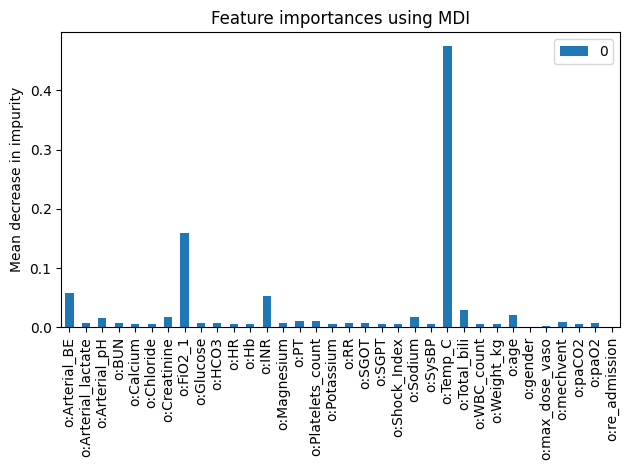

In [29]:
fig, ax = plt.subplots()
df.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [30]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)



In [59]:
forest_importances = pd.DataFrame(result.importances_mean, index=feature_names)
forest_importances

,0
o:Arterial_BE,0.0
o:Arterial_lactate,0.0
o:Arterial_pH,0.0
o:BUN,0.0
o:Calcium,0.0
...,...
o:max_dose_vaso,0.0
o:mechvent,0.0
o:paCO2,0.0
o:paO2,0.0


In [31]:
df = pd.pivot_table(forest_importances, index=forest_importances.index,aggfunc='sum')

In [76]:
df.columns

RangeIndex(start=0, stop=1, step=1)

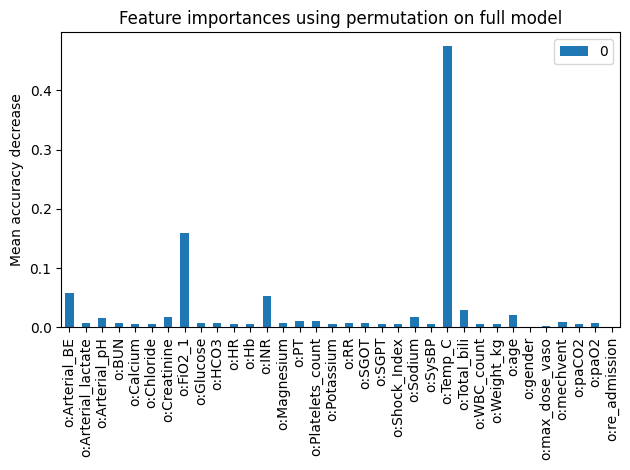

In [32]:
fig, ax = plt.subplots()
df.plot.bar(ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### apply tfidf to text, and evaluate feature importance

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
t.columns

Index(['Unnamed: 0', 'subject_id', 'hadm_id', 'category', 'description',
       'iserror', 'text', 'charttime', 'chartdate', 'storetime', 'm:icustayid',
       'sepsis_label', 'm:presumed_onset', 'granular_label'],
      dtype='object')

In [38]:
t.isna().sum()

Unnamed: 0                0
subject_id                0
hadm_id               94169
category                  0
description               0
iserror             1310775
text                      0
charttime            220971
chartdate                 0
storetime            583274
m:icustayid               0
sepsis_label              0
m:presumed_onset          0
granular_label            0
dtype: int64

In [8]:
data = t.drop(columns=['Unnamed: 0', 'subject_id', 'hadm_id', 'category', 'description',
       'iserror', "charttime", "storetime"])
text_ = data.loc[t["m:icustayid"].isin(ids)]

In [41]:
text_.head()

,text,chartdate,m:icustayid,sepsis_label,m:presumed_onset,granular_label
2,[**2101-10-20**] 5:49 PM\n CT ABDOMEN W/O CONT...,4.159210e+09,211552.0,0.0,0.0,0
3,[**2101-10-20**] 6:16 PM\n CHEST (PORTABLE AP)...,4.159210e+09,211552.0,0.0,0.0,0
4,[**2101-10-20**] 10:23 PM\n CHEST (PORTABLE AP...,4.159210e+09,211552.0,0.0,0.0,0
5,[**2101-10-21**] 1:00 AM\n CHEST (PORTABLE AP)...,4.159296e+09,211552.0,0.0,0.0,0
6,[**2101-10-21**] 6:10 AM\n CHEST (PORTABLE AP)...,4.159296e+09,211552.0,0.0,0.0,0


In [9]:
vct = TfidfVectorizer()
transformed =vct.fit_transform(text_["text"])

In [10]:
print(len(vct.vocabulary_))

454227


In [46]:
"""vct_features = vct.get_feature_names_out()
for word in vct_features:
    i = vct.vocabulary_.get(word)
    print(f"{word} {vct.idf_[i]}")"""

00 3.2105137533540304
000 5.004577635750487
0000 7.5589193519928175
0000am 13.47727542728016
0000d 13.98810105104615
0000h 13.70041897859437
0000hours 14.393566159154316
0000hr 11.449127179987876
0000hrs 12.60180668992626
0000s 14.393566159154316
0000were 14.393566159154316
0001 10.24252625325567
0002 11.951219123785112
0003 11.86783751484606
0003h 14.393566159154316
0004 11.5603528150981
0005 11.531365278224847
0006 11.685515958052106
0007 11.280050849943942
0008 12.196341581818096
0008mcg 14.393566159154316
0009 12.688818066915891
0009mc 14.393566159154316
000cc 11.908659509366315
000ccs 13.70041897859437
000cfu 14.393566159154316
000crp 14.393566159154316
000gnr 13.98810105104615
000international 14.393566159154316
000iu 13.70041897859437
000k 13.140803190658948
000klebsiella 13.70041897859437
000liters 14.393566159154316
000m 14.393566159154316
000mcg 12.784128246720215
000mg 10.368214468419167
000ml 13.007271798034425
000mls 13.98810105104615
000ng 13.98810105104615
000o 14.393566

KeyboardInterrupt: 

In [57]:
text_.granular_label

2          0
3          0
4          0
5          0
6          0
          ..
1957226    0
1957227    0
1957228    0
1957229    0
1957230    0
Name: granular_label, Length: 1311540, dtype: int32

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(text_.text[:10000], text_.granular_label[:10000], test_size=0.30, random_state=100,stratify=text_.granular_label[:10000])

In [16]:
print(f"Shape of X_train: {len(X_train)}")
print(f"Shape of X_test: {len(X_test)}")
print("Class Balance in Training Data:", Counter(y_train).items())
print("Class Balance in Test Data:", Counter(y_test).items())

Shape of X_train: 7000
Shape of X_test: 3000
Class Balance in Training Data: dict_items([(1, 2402), (0, 4598)])
Class Balance in Test Data: dict_items([(0, 1971), (1, 1029)])


In [19]:
clf = Pipeline([
    ("vct", TfidfVectorizer(analyzer="char", ngram_range=(1, 2))),
    ("sparse2dense", FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ("forest", RandomForestClassifier(random_state=0))
])

In [20]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.96      0.84      1971
           1       0.83      0.34      0.48      1029

    accuracy                           0.75      3000
   macro avg       0.78      0.65      0.66      3000
weighted avg       0.77      0.75      0.71      3000



In [22]:
# len of tfidf vocab and feature_importances
print(len(clf.named_steps["vct"].vocabulary_), len(clf.named_steps["forest"].feature_importances_))

print(list(clf.named_steps["vct"].vocabulary_.keys())[:10])

409145 409145
['nursing', 'progress', 'note', '0700', '1900', 'events', 'extubated', 'given', '20', 'mg']


In [23]:
importances = clf.named_steps["forest"].feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.named_steps["forest"]], axis=0)


In [25]:
forest_importances = pd.DataFrame(importances, index=list(clf.named_steps["vct"].vocabulary_.keys()), columns=["importance_score"])
forest_importances

,importance_score
nursing,0.000101
progress,0.000000
note,0.000000
0700,0.000000
1900,0.000000
...,...
ligaments and,0.000000
and transection,0.000000
level intraspinal,0.000000
intraspinal hematoma,0.000000


In [129]:
df = pd.pivot_table(forest_importances, index=forest_importances.index,aggfunc='sum')

In [130]:
df.sort_values(by=["importance_score"], ascending=False, inplace=True)
df[:50]

,importance_score
=,0.026769
],0.023789
x,0.022803
[,0.022731
j,0.022444
q,0.022274
>,0.022125
^,0.021948
!,0.021881
{,0.021785


In [35]:
corpus = []
for id in tqdm(ids[0:1]):
    #grab data of one patient
    df_raw = text_.loc[text_["m:icustayid"] == id] 
    #drop icustayid to avoid learning the id to label correspondence
    #d = df_raw.drop(columns=["icustay_id", "charttime"])
    #flatten all features and corresponding values of all timesteps into single sequence, used for classifier, feature importance etc
    temp2.append(list(df_raw["text"].values.flatten()))
df_raw = text_.loc[text_["icustay_id"] == id] 
d = df_raw.drop(columns=["icustay_id"])

100%|██████████| 1/1 [00:00<00:00, 334.50it/s]


#### After building tfidf, feature extraction:

In [34]:
temp2 = []
for id in tqdm(ids[0:1]):
    #grab data of one patient
    df_raw = text_.loc[text_["icustay_id"] == id] 
    start = np.min(df_raw["charttime"])
    end = start+min_step*3600
    print(df_raw,start, end)
    #drop icustayid to avoid learning the id to label correspondence
    #d = df_raw.drop(columns=["icustay_id", "charttime"])
    #flatten all features and corresponding values of all timesteps into single sequence, used for classifier, feature importance etc
    temp2.append(list(df_raw["text"].values.flatten()))
df_raw = text_.loc[text_["icustay_id"] == id] 
d = df_raw.drop(columns=["icustay_id", "charttime"])

100%|██████████| 1/1 [00:00<00:00, 66.53it/s]

                                                      text     charttime  \
1147423  [**2199-8-3**] 2:08 AM\n CHEST PORT. LINE PLAC...  7.245080e+09   
1147424  Admission to Sicu note\nPlease see careview fo...  7.245091e+09   
1147425  [**2199-8-3**] 8:03 AM\n CT ABD W&W/O C; CT PE...  7.245101e+09   
1147426  NPN (SEE CAREVUE FOR SPECIFICS)\n\n[**Name (NI...  7.245124e+09   
1147427  [**2199-8-3**] 3:26 PM\n PTC                  ...  7.245128e+09   
1147428  ADDENDUM:\nPT TO IR FOR DRAIN PLACEMENT, INTUB...  7.245138e+09   
1147429  Resp. care note - Intubated pt. transffered fr...  7.245140e+09   
1147430  [**2199-8-3**] 8:10 PM\n CHEST (PORTABLE AP); ...  7.245145e+09   
1147431  SICU NPN\nS-Sedated and intubated.\n\nSEE CARE...  7.245164e+09   
1147432  [**2199-8-4**] 3:34 AM\n CHEST (PORTABLE AP)  ...  7.245171e+09   
1147433  Resp Care Note, Pt remains on current vent set...  7.245172e+09   
1147434  ADDEDUM to SICU NPN\nEVENT:[** **] non-sustain...  7.245174e+09   
1147435  NPN

In [29]:
temp2[0][2]

'[**2199-8-3**] 8:03 AM\n CT ABD W&W/O C; CT PELVIS W/CONTRAST                            Clip # [**Clip Number (Radiology) 19279**]\n Reason: assess for intraabdominal process\n Admitting Diagnosis: S/P RESECTION\n Field of view: 36 Contrast: OPTIRAY Amt: 150\n ______________________________________________________________________________\n [**Hospital 2**] MEDICAL CONDITION:\n   48 year old man with s/p liver resection for cholangiocarcinoma, post op bile\n  leak, CT abd to r/o fluid collection\n REASON FOR THIS EXAMINATION:\n  assess for intraabdominal process\n No contraindications for IV contrast\n ______________________________________________________________________________\n                                 FINAL REPORT\n ABDOMEN CT WITH AND WITHOUT CONTRAST.\n\n HISTORY:  Status post right hepatectomy for cholangiocarcinoma with postop\n bile leak.  Evaluate for fluid collection or intra-abdominal process. Patient\n presenting with fevers and rigors.\n\n TECHNIQUE:  Pre- and po